# 22S1-AI6124 Pseudo Outer-Product Fuzzy Neural Network (POPFNN) Tutorial Assignment 4
Created by A/Prof Kai Keng ANG (kkang@i2r.a-star.edu.sg, kkang@ntu.edu.sg). Last modified 5 Oct 2022

Submitted by: Sean Goh Ann Ray
Mat ID: G2202190G

## Instructions

Enter your name according to NTU Learn, and your student ID above. Do not include the square brackets. Please save the file as POPFNN_[Student name].ipynb and submit in NTU Learn.

There are 10 questions in this assignment. Please read the question and hints carefully. 

## Objective
In this tutorial, you will implement derivation of fuzzy if-then rules using Pseudo Outer Product (POP) Learning in POPFNN.

After completing this tutorial, you will know:

* How to apply what you leaned in the previous tuorial assignment 3 to implement  membership functions
* How to implement a function to generate a given number of membership functions that span the input space of the data
* How to apply LVQ algorithm in the previous tutorial assignment 4 to generate membership functions from the dataset, and not just the centroids
* To to implement and apply POP learning to identify if-then-fuzzy rules using the generated membership functions and the dataset

# Introduction

Before we start, first install and import the necessary libraries.

In [1]:
!pip install -U fuzzylab
import numpy as np
import matplotlib.pyplot as plt
import sys
import fuzzylab as fz
from random import randrange


## 1. Fuzzy Membership Function

In this tutorial, we will use the Guassian combination membership function. This function has 2 parameters more than the Gaussian membership function. Both are provided for reference. An evalmf function is also included to call the respective function to evaluate a membership output. 

In [2]:
def gaussmf(x, params):    
    assert len(params) == 2, 'Gaussmf function must have 2 parameters.'
    sig, c = np.asarray(params)
    return np.exp(-pow((x - c), 2) / (2 * pow(sig, 2)))

def gauss2mf(x, params):
    assert len(params) == 4, 'Gauss2mf function must have 4 parameters.'
    sig1, c1, sig2, c2 = np.asarray(params)
    assert c1 <= c2, 'c1 <= c2 is required.'
    if np.isscalar(x):
        if x<=c1:
            y=gaussmf(x, [sig1, c1])
        else:
            y=gaussmf(x,[sig2, c2])
    else:
        y = np.ones(len(x))
        idx1 = (x <= c1)
        idx2 = (x > c2)
        y[idx1] = gaussmf(x[idx1], [sig1, c1])
        y[idx2] = gaussmf(x[idx2], [sig2, c2])
    return y

# This function overwrites the evalmf function of the fuzzy logic toolbox by looking for the function name defined by
# mf.Type and calling it directly.
def evalmf(mf, x):
    possibles = globals().copy()
    possibles.update(locals())
    method = possibles.get(mf.Type)
    return method(x, mf.Parameters)

## 2. Fuzzy Membership Function class

Next we create a Fuzzy Membership function class to store the Fuzzy Membership function created, and a POPFNN class to store the input, output and fuzzy rules created.

In [3]:
class fuzzymf(object):
    def __init__(self, Type, Parameters):
        self.Type = Type
        self.Parameters = Parameters
    def __repr__(self):
            return 'fismf, '\
                ' Type: %s, '\
                ' Parameters: %s\n'\
                % (self.Type,self.Parameters)

class popfnn(object):
    In_mf:fuzzymf
    Out_mf:fuzzymf
    N_inputs:int
    N_outlabels:int
    Lut_m:np
    Lut_d:np
    N_rules:int
    Pweights:np

    def __init__(self, In_mf, Out_mf):
        self.In_mf = In_mf
        self.Out_mf = Out_mf

        self.N_inputs=len(self.In_mf) # no. of features
        self.N_outlabels=len(self.Out_mf[0]) # no. of membership functions of label
        self.Lut_m=np.empty(self.N_inputs, np.int8)
        self.Lut_d=np.empty(self.N_inputs, np.int8)       
       
        # Calculate lookup tables for rule access
        self.N_rules = 1
        for i in range(self.N_inputs):
            self.Lut_m[i] = len(self.In_mf[i]) # no. of membership functions in feature i
            self.Lut_d[i] = 1
            self.N_rules = self.N_rules * self.Lut_m[0] # no. of rules = (no. of membership functions)**(no. of features)
            for j in range(i):
                self.Lut_d[j] = self.Lut_d[j] * self.Lut_m[j]
        
        # Initialize pseudo weights for all rules
        self.pweights = np.zeros([self.N_rules,self.N_outlabels])
        self.consequent = []

    # returns the membership label given rule number and the ninput
    def getlabel(self, rule, ninput):
        return (int((int(rule)/(self.Lut_d[ninput]))%self.Lut_m[ninput]));

    # prints all the rules
    def printruleslabels(self):
        print('N_inputs=',self.N_inputs)
        print('N_rules=',self.N_rules)
        print('N_output_mf=',self.N_outlabels)
        if len(self.consequent) < 1:
            print('rule_number, labels, pweights')
            for i in range(self.N_rules): # for each rule
                print(i,end = ' ')
                for j in range(self.N_inputs): # for each feature
                    print(self.getlabel(i,j),end = ' ')
                for j in range(self.N_outlabels): # for each linguistic label
                    print(self.pweights[i][j],end = ' ')
                print('')
        else:
            print('rule_number, labels, pweights, consequent label')
            for i in range(self.N_rules): # for each rule
                print(i,end = ' ')
                for j in range(self.N_inputs): # for each feature
                    print(self.getlabel(i,j),end = ' ')
                for j in range(self.N_outlabels): # for each linguistic label
                    print(self.pweights[i][j],end = ' ')
                print(self.consequent_label[i])
            
    def poplearn(self, x, y):
        '''
        x: one data sample with 2 features (1 by 2 matrix)
        y: label of data sample
        '''
        for r in range(self.N_rules): # for each rule
            min_t=1.0
            for i in range(self.N_inputs): # for each feature
                # Get the label of input i for rule r
                label=self.getlabel(r,i)
                # Compute membership of input i
                t=evalmf(self.In_mf[i][label],x[i])
                # Compute min across all input membership functions
                min_t=min(min_t,t)
            for i in range(self.N_outlabels): # for each linguistic label (AKA output membership function)
                t=evalmf(self.Out_mf[0][i],y)
                self.pweights[r][i]+=min_t*t
                
    #Enter code for question 8 here
    def identify_rules(self):
        self.consequent = np.max(self.pweights, axis=1)
        self.consequent_label = np.argmax(self.pweights, axis=1)
        self.consequent_label = self.consequent_label + 1
        return self.pweights
    

## 3. Learning Fuzzy Membership function by spanning the input space

Next we crate a simple function to generate a given number of membership functions that span the input space of the data.

In [4]:
# This function creates nlabels number of gauss2mf that spans min and max of the inputs
def span_learnmem(x, params):

    assert len(params) == 2, 'spam_learnmem function must have 2 parameters.'
    nlabels, width = np.asarray(params)
    nlabels=int(nlabels)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)    
    
    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)
    
    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=(centroids[1]-centroids[0])*width        
        mf=[]
        for j in range(nlabels):
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)  
    return fis


## 4. Generate Training dataset

Now we generate a dataset to train the Neuro Fuzzy System.

Text(0, 0.5, '$x_2$')

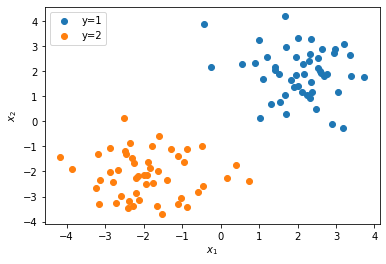

In [5]:
dataset = np.random.randn(100,2)
dataset[0:50]+=(+2)
dataset[50:100]+=(-2)
labels=np.array([1]*50)
labels=np.append(labels,[2]*50)
#labels=labels.transpose()
plt.scatter(dataset[labels==1,0], dataset[labels==1,1])
plt.scatter(dataset[labels==2,0], dataset[labels==2,1])
plt.legend(['y=1','y=2'])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

## 5. Train the fuzzy membership functions (ALMOST DONE, left Qn7)

Now we begin to train the fuzzy membership functions. After POPFNN initializes the rule space based on the input and output membership functions. The function printrulelabels prints out all the rules, the membership function labels for each input, and the pseudo weights of each rule.

In [6]:
inmf = span_learnmem(dataset, [2.0, 0.5])
outmf = span_learnmem(labels, [2.0, 0.5])
nf=popfnn(In_mf=inmf, Out_mf=outmf)
nf.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 0.0 0.0 
1 0 1 0.0 0.0 
2 1 0 0.0 0.0 
3 1 1 0.0 0.0 


<font color=red>Question 1</font>: How many rules are initialized in the above code? <font color='red'>(1 mark)</font>

4

<font color=red>Question 2</font>: How many rules are generated if you change span_learnmem to generate 4 membership functions instead of 2? <font color='red'>(1 mark)</font>

In [7]:
# Modify code for question 2 here (DONE)
inmf2 = span_learnmem(dataset, [4.0, 0.5])
outmf2 = span_learnmem(labels, [4.0, 0.5])
nf2=popfnn(In_mf=inmf2, Out_mf=outmf2)
nf2.printruleslabels()

N_inputs= 2
N_rules= 16
N_output_mf= 4
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0 0.0 
1 0 1 0.0 0.0 0.0 0.0 
2 0 2 0.0 0.0 0.0 0.0 
3 0 3 0.0 0.0 0.0 0.0 
4 1 0 0.0 0.0 0.0 0.0 
5 1 1 0.0 0.0 0.0 0.0 
6 1 2 0.0 0.0 0.0 0.0 
7 1 3 0.0 0.0 0.0 0.0 
8 2 0 0.0 0.0 0.0 0.0 
9 2 1 0.0 0.0 0.0 0.0 
10 2 2 0.0 0.0 0.0 0.0 
11 2 3 0.0 0.0 0.0 0.0 
12 3 0 0.0 0.0 0.0 0.0 
13 3 1 0.0 0.0 0.0 0.0 
14 3 2 0.0 0.0 0.0 0.0 
15 3 3 0.0 0.0 0.0 0.0 


16

Text(0.5, 1.0, 'Membership Functions for Input $x_1$')

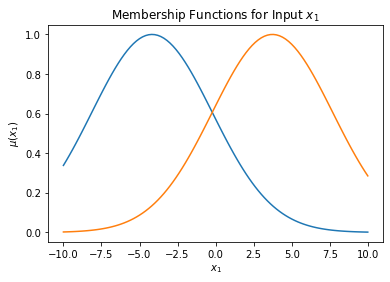

In [8]:
x = np.linspace(-10, 10, 101)
plt.plot(x, evalmf(inmf[0][0], x))
plt.plot(x, evalmf(inmf[0][1], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_1$')

Text(0.5, 1.0, 'Membership Functions for Input $x_2$')

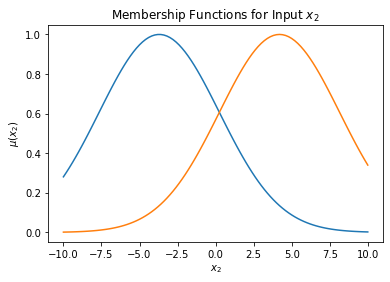

In [9]:
plt.plot(x, evalmf(inmf[1][0], x))
plt.plot(x, evalmf(inmf[1][1], x))
plt.xlabel('$x_2$')
plt.ylabel('$\mu(x_2)$')
plt.title('Membership Functions for Input $x_2$')

Text(0.5, 1.0, 'Membership Functions for Output $y_1$')

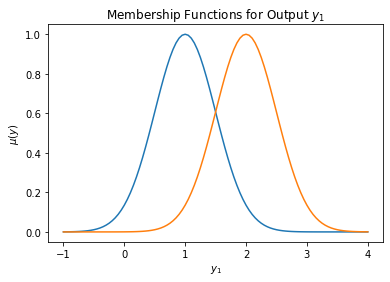

In [10]:
y = np.linspace(-1, 4, 101)
plt.plot(y, evalmf(outmf[0][0], y))
plt.plot(y, evalmf(outmf[0][1], y))
plt.xlabel('$y_1$')
plt.ylabel('$\mu(y)$')
plt.title('Membership Functions for Output $y_1$')

<font color=red>Question 3</font>: Modify the span_learnmem to include a parameter tail. If parameter is true, one end of the left most and right most membership function will yield 1, but not the middle of the membership function. Hint: Change one of the parameters. Another hint, the value is one from the sys module. <font color='red'>(1 mark)</font>

In [11]:
# Modify the below code here for Question 3. (DONE)
def span_learnmem1(x, params):

    assert len(params) == 3, 'spam_learnmem1 function must have 3 parameters.'
    nlabels, width, tail = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)    
    
    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)
    
    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=(centroids[1]-centroids[0])*width        
        mf=[]
        if tail==False:
            for j in range(nlabels):
                mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        else:
            for j in range(nlabels):
                if j==0:
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -sys.hash_info.inf, sig, centroids[j]]))
                elif j!=(nlabels-1):
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
                else:
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, sys.hash_info.inf]))
        fis.append(mf)  
    return fis # matrix with size (no. of features) by (no. of membership functions)


<font color=red>Question 4</font>: Use the above modified span_learnmem and plot nlabels=3 membership functions with tail=true for $x_1$ <font color='red'>(1 mark)</font>

N_inputs= 2
N_rules= 9
N_output_mf= 3
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0 
1 0 1 0.0 0.0 0.0 
2 0 2 0.0 0.0 0.0 
3 1 0 0.0 0.0 0.0 
4 1 1 0.0 0.0 0.0 
5 1 2 0.0 0.0 0.0 
6 2 0 0.0 0.0 0.0 
7 2 1 0.0 0.0 0.0 
8 2 2 0.0 0.0 0.0 


Text(0.5, 1.0, 'Membership Functions for Input $x_1$')

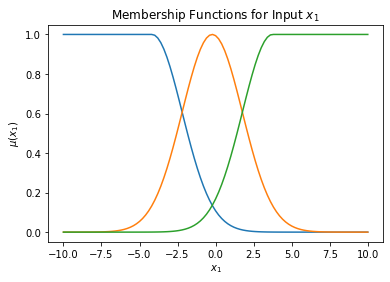

In [12]:
# Enter code here for Question 4. (DONE)

inmf3 = span_learnmem1(dataset, [3.0, 0.5, True])
outmf3 = span_learnmem1(labels, [3.0, 0.5, True])
nf3=popfnn(In_mf=inmf3, Out_mf=outmf3)
nf3.printruleslabels()

x = np.linspace(-10, 10, 101)
plt.plot(x, evalmf(inmf3[0][0], x))
plt.plot(x, evalmf(inmf3[0][1], x))
plt.plot(x, evalmf(inmf3[0][2], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_1$')

<font color=red>Question 5</font>: Now modify span_learnmem to delete the width parameter and automatically compute the width such that the membership functions intersect at value $\mu=0.5$ in the middle of the centroid. Retain the tail parameter. <font color='red'>(1 mark)</font>

In [13]:
# This function creates nlabels number of gauss2mf that spans min and max of the inputs (DONE)
def span_learnmem2(x, params):

    assert len(params) == 2, 'spam_learnmem function must have 2 parameters.'
    nlabels, tail = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)    
    
    print('x.ndim = ', x.ndim)
    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)
    
    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
            print(f'centroids of dim {i+1} = {centroids}')
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
            print(f'centroids of dim {i+1} = {centroids}')
        
        sig=(centroids[1]-centroids[0])*0.5 / np.sqrt(-2*np.log(0.5))

        mf=[]
        if tail==False:
            for j in range(nlabels):
                mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        else:
            for j in range(nlabels):
                if j==0:
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -sys.hash_info.inf, sig, centroids[j]]))
                elif j!=(nlabels-1):
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
                else:
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, sys.hash_info.inf]))
        fis.append(mf)
    print('')
    return fis

<font color=red>Question 6</font>: Use the above modified span_learnmem and plot nlabels=4 membership functions with tail=true for $x_2$ <font color='red'>(1 mark)</font>

x.ndim =  2
centroids of dim 1 = [-4.17651556 -1.53869894  1.09911769  3.73693431]
centroids of dim 2 = [-3.70352194 -1.06970907  1.5641038   4.19791667]

x.ndim =  1
centroids of dim 1 = [1.         1.33333333 1.66666667 2.        ]

N_inputs= 2
N_rules= 16
N_output_mf= 4
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0 0.0 
1 0 1 0.0 0.0 0.0 0.0 
2 0 2 0.0 0.0 0.0 0.0 
3 0 3 0.0 0.0 0.0 0.0 
4 1 0 0.0 0.0 0.0 0.0 
5 1 1 0.0 0.0 0.0 0.0 
6 1 2 0.0 0.0 0.0 0.0 
7 1 3 0.0 0.0 0.0 0.0 
8 2 0 0.0 0.0 0.0 0.0 
9 2 1 0.0 0.0 0.0 0.0 
10 2 2 0.0 0.0 0.0 0.0 
11 2 3 0.0 0.0 0.0 0.0 
12 3 0 0.0 0.0 0.0 0.0 
13 3 1 0.0 0.0 0.0 0.0 
14 3 2 0.0 0.0 0.0 0.0 
15 3 3 0.0 0.0 0.0 0.0 


Text(0.5, 1.0, 'Membership Functions for Input $x_2$')

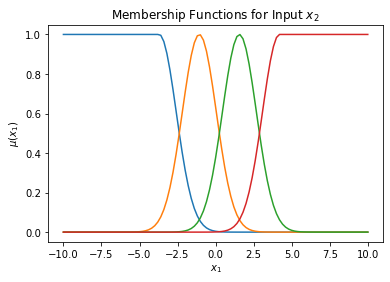

In [14]:
# Enter code here for Question 6. (DONE)

inmf4 = span_learnmem2(dataset, [4.0, True])
outmf4 = span_learnmem2(labels, [4.0, True])
nf4=popfnn(In_mf=inmf4, Out_mf=outmf4)
nf4.printruleslabels()

x = np.linspace(-10, 10, 101)
for i in range(len(inmf4[1])):
    plt.plot(x, evalmf(inmf4[1][i], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_2$')

<font color=red>Question 7</font>: Now create a new LVQ_learnmem with nlabels and tail parameters. Then plot nlabels=2 membership functions with tail=true for $x_1$. Refer to code from previous tutorial. <font color='red'>(1 mark)</font>

Random initial centroids: 
 [[-2.66552926 -1.92605386]
 [ 2.48810345  0.48814318]]
>epoch=5, lrate=0.736, error=138.835
>epoch=10, lrate=0.656, error=135.172
>epoch=15, lrate=0.576, error=131.921
>epoch=20, lrate=0.496, error=129.126
>epoch=25, lrate=0.416, error=126.844
>epoch=30, lrate=0.336, error=125.231
>epoch=35, lrate=0.256, error=124.085
>epoch=40, lrate=0.176, error=122.518
>epoch=45, lrate=0.096, error=119.956
>epoch=50, lrate=0.016, error=117.248
Final centroids (ordered by dimension 1): 
 [[-1.90182733 -2.05966271]
 [ 2.04957419  1.88813413]] 

ninputs = 2
centroids of dim 1 = [-1.90182733  2.04957419]
centroids of dim 2 = [-2.05966271  1.88813413]

ninputs = 1
centroids of dim 1 = [1. 2.]

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 0.0 0.0 
1 0 1 0.0 0.0 
2 1 0 0.0 0.0 
3 1 1 0.0 0.0 


Text(0.5, 1.0, 'Membership Functions for Output $y_1$')

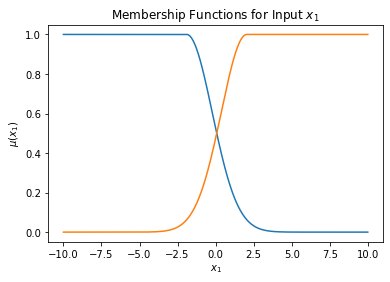

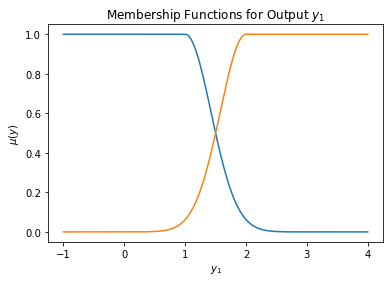

In [15]:
# Enter code here for Question 7. (DONE)

# Assign a random codebook vector from the training data
def random_weight(traindata):
    n_records = len(traindata)   
    weight = traindata[randrange(n_records)]
    return weight


def find_winner(weights, test_sample):
    distances = list()
    for weight_index, weight in enumerate(weights):
        dist = np.sqrt(np.sum((weight-test_sample)**2))
        distances.append((weight_index, dist))
    distances.sort(key=lambda tuple: tuple[1])
    return distances[0][0]


def LVQ_learnmem(traindata, params):

    assert len(params) == 2, 'LVQ_learnmem function must have 2 parameters.'
    nlabels, tail = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)
    
    # initialize weights
    weights = [random_weight(traindata) for i in range(nlabels)]
    weights = np.asarray(weights)
    if weights.ndim > 1:
        print('Random initial centroids: \n', weights)
    
    # perform LVQ only on train data and not labels, output weights is centers of clusters
    if type(traindata[0]) is not np.int64:
        for epoch in range(50):
            rate = 0.8 * (1.0-(epoch/float(50)))
            sum_error = 0.0
            for row in traindata:
                winner_index = find_winner(weights, row)
                error = (row - weights[winner_index])
                sum_error = sum_error + np.sqrt(sum(error**2))
                weights[winner_index] = weights[winner_index] + rate * error
            if (epoch+1)%5 == 0:
                print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch+1, rate, sum_error))

    # sort nweights by dim1 for order
    weights = np.asarray(weights)
    if weights.ndim > 1:
        weights = weights[weights[:, 0].argsort()]
        print(f'Final centroids (ordered by dimension 1): \n {weights} \n')
    
    # First get the max and min of each dimension
    maxx=np.amax(traindata, axis=0)
    minx=np.amin(traindata, axis=0)    
    
    if traindata.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(traindata,1)
    print(f'ninputs = {ninputs}')
    
    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
            print(f'centroids of dim {i+1} = {centroids}')
        else:
            centroids = weights[:,i]
            print(f'centroids of dim {i+1} = {centroids}')
        

        mf=[]
        if tail==False:
            for j in range(nlabels):
                if j==0:
                    sig = (centroids[j+1]-centroids[j])*0.5 / np.sqrt(-2*np.log(0.5))
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
                elif j!=(nlabels-1):
                    sigl = (centroids[j]-centroids[j-1])*0.5 / np.sqrt(-2*np.log(0.5))
                    sigr = (centroids[j+1]-centroids[j])*0.5 / np.sqrt(-2*np.log(0.5))
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sigl, centroids[j], sigr, centroids[j]]))
                else:
                    sig = (centroids[j]-centroids[j-1])*0.5 / np.sqrt(-2*np.log(0.5))
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        else:
            for j in range(nlabels):
                if j==0:
                    sig = (centroids[j+1]-centroids[j])*0.5 / np.sqrt(-2*np.log(0.5))
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -sys.hash_info.inf, sig, centroids[j]]))
                elif j!=(nlabels-1):
                    sigl = (centroids[j]-centroids[j-1])*0.5 / np.sqrt(-2*np.log(0.5))
                    sigr = (centroids[j+1]-centroids[j])*0.5 / np.sqrt(-2*np.log(0.5))
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sigl, centroids[j], sigr, centroids[j]]))
                else:
                    sig = (centroids[j]-centroids[j-1])*0.5 / np.sqrt(-2*np.log(0.5))
                    mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, sys.hash_info.inf]))
        fis.append(mf)
    print('')
    return fis


inmf5 = LVQ_learnmem(dataset, [2.0, True])
outmf5 = LVQ_learnmem(labels, [2.0, True])
nf5=popfnn(In_mf=inmf5, Out_mf=outmf5)
nf5.printruleslabels()

x = np.linspace(-10, 10, 1001)
for i in range(len(inmf5[0])):
    plt.plot(x, evalmf(inmf5[0][i], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_1$')

plt.figure()
y = np.linspace(-1, 4, 1001)
for i in range(len(outmf5[0])):
    plt.plot(y, evalmf(outmf5[0][i], y))
plt.xlabel('$y_1$')
plt.ylabel('$\mu(y)$')
plt.title('Membership Functions for Output $y_1$')

## 6. Train the POPFNN using POP learning
Finally we train the POPFNN Neuro Fuzzy System using Pseudo Outer-Product Learning algorithm. Becareful that you do not change nf along the way. This code below should produce only 4 if then fuzzy rules.

In [16]:
# Perform POP learning 
for k in range(len(dataset)):
    nf.poplearn(dataset[k],labels[k])
nf.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 18.416272106242427 41.99112337176059 
1 0 1 16.836220611650628 16.367856228316207 
2 1 0 21.076330697948713 21.0540630502538 
3 1 1 41.66483659342213 18.11257035675487 


<font color=red>Question 8</font>: Examine the pseudo weights for each output label in the output above. Create a function in POPFNN class call identify rules to identify the consequent for each rule. Also modify the printruleslabels function to print the label of the consequent after the pseudo weight. <font color='red'>(1 mark)</font>

In [17]:
# Enter code here for Question 8.
nf.identify_rules()
nf.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights, consequent label
0 0 0 18.416272106242427 41.99112337176059 2
1 0 1 16.836220611650628 16.367856228316207 1
2 1 0 21.076330697948713 21.0540630502538 1
3 1 1 41.66483659342213 18.11257035675487 1


<font color=red>Question 9</font>: Now change the generation of membership function to LVQ with nlabels=2 and tail=true. Retrain the fuzzy rules and print the rules for inspection. Any changes in the rules identified? <font color='red'>(1 mark)</font>

In [18]:
# Enter code for Question 9.
inmf6 = LVQ_learnmem(dataset, [2.0, True])
outmf6 = LVQ_learnmem(labels, [2.0, True])
nf6=popfnn(In_mf=inmf6, Out_mf=outmf6)

for k in range(len(dataset)):
    nf6.poplearn(dataset[k],labels[k])

nf6.identify_rules()
nf6.printruleslabels()

# Yes, rules 1 and 2 have changed.
# rule 1 has changed from 'if x_1 is 0 and x_2 is 1, then y is 1' to 'if x_1 is 0 and x_2 is 1, then y is 2'
# rule 2 has changed from 'if x_1 is 1 and x_2 is 0, then y is 1' to 'if x_1 is 1 and x_2 is 0, then y is 2'

Random initial centroids: 
 [[-2.51677725  0.12521921]
 [-2.72634667 -3.25269349]]
>epoch=5, lrate=0.736, error=138.835
>epoch=10, lrate=0.656, error=135.172
>epoch=15, lrate=0.576, error=131.921
>epoch=20, lrate=0.496, error=129.126
>epoch=25, lrate=0.416, error=126.844
>epoch=30, lrate=0.336, error=125.231
>epoch=35, lrate=0.256, error=124.085
>epoch=40, lrate=0.176, error=122.518
>epoch=45, lrate=0.096, error=119.956
>epoch=50, lrate=0.016, error=117.248
Final centroids (ordered by dimension 1): 
 [[-1.90182733 -2.05966271]
 [ 2.04957419  1.88813413]] 

ninputs = 2
centroids of dim 1 = [-1.90182733  2.04957419]
centroids of dim 2 = [-2.05966271  1.88813413]

ninputs = 1
centroids of dim 1 = [1. 2.]

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights, consequent label
0 0 0 4.52726910612926 39.57974663735511 2
1 0 1 1.954078209639527 4.799110022533803 2
2 1 0 2.617797128516755 5.798338946373031 2
3 1 1 9.530009330578364 2.718549628167057 1


<font color=red>Question 10</font>: Now inspect the pseudo weights again. Some of the rules have pseudo weights that are very similar for both output labels. Implement another function to identify the more significant rules such that the pseduo weight for a particular output label is much higher than the other output labels. <font color='red'>(1 mark)</font>

In [19]:
# Enter code for Question 10.
def trim_rules(pweights):
    rule_number = np.empty((0,1), int)
    labels = np.empty((0,2), int)
    pweight = np.empty((0,2), float)
    consequent_label = np.empty((0,1), int)
    for i in range(len(pweights)):
        if (pweights[i][0]/pweights[i][1] > 2 or pweights[i][1]/pweights[i][0] > 2) and (abs(pweights[i][0]-pweights[i][1])>5):
            rule_number = np.append(rule_number, i)
            if i == 0:
                labels = np.append(labels,np.array([[0, 0]]), axis=0)
            elif i == 1:
                labels = np.append(labels,np.array([[0, 1]]), axis=0)
            elif i == 2:
                labels = np.append(labels,np.array([[1, 0]]), axis=0)
            elif i == 3:
                labels = np.append(labels,np.array([[1, 1]]), axis=0)
            pweight = np.append(pweight, [pweights[i]], axis=0)
            consequent_label = np.append(consequent_label, np.argmax(pweights[i])+1)
            print(f'{i} rule retained')
        else:
            print(f'{i} rule removed')
    print('After rule trimming:')
    print('rule_number, labels, pweights, consequent label')
    for i in range(len(rule_number)): # for each retained rule
        print(rule_number[i],end = ' ')
        for j in range(2):
            print(labels[i,j],end = ' ')
        for j in range(2):
            print(pweight[i,j],end = ' ')
        print(consequent_label[i])

print('Original POPFNN algorithm:')
pweights = nf.identify_rules()
print('Before rule trimming:')
nf.printruleslabels()
trim_rules(pweights)
print('')

print('With LVQ algorithm:')
pweights = nf6.identify_rules()
print('Before rule trimming:')
nf6.printruleslabels()
trim_rules(pweights)

Original POPFNN algorithm:
Before rule trimming:
N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights, consequent label
0 0 0 18.416272106242427 41.99112337176059 2
1 0 1 16.836220611650628 16.367856228316207 1
2 1 0 21.076330697948713 21.0540630502538 1
3 1 1 41.66483659342213 18.11257035675487 1
0 rule retained
1 rule removed
2 rule removed
3 rule retained
After rule trimming:
rule_number, labels, pweights, consequent label
0 0 0 18.416272106242427 41.99112337176059 2
3 1 1 41.66483659342213 18.11257035675487 1

With LVQ algorithm:
Before rule trimming:
N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights, consequent label
0 0 0 4.52726910612926 39.57974663735511 2
1 0 1 1.954078209639527 4.799110022533803 2
2 1 0 2.617797128516755 5.798338946373031 2
3 1 1 9.530009330578364 2.718549628167057 1
0 rule retained
1 rule removed
2 rule removed
3 rule retained
After rule trimming:
rule_number, labels, pweights, consequent label
0 0 0 4.52726910612926 39.57974